# Example - Kickstarter

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Target" data-toc-modified-id="Target-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Target</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#Feature-Importance-migration" data-toc-modified-id="Feature-Importance-migration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance migration</a></span></li><li><span><a href="#Reverse-Learning-Curve" data-toc-modified-id="Reverse-Learning-Curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reverse Learning Curve</a></span></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Feature-Impact" data-toc-modified-id="Feature-Impact-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Impact</a></span></li><li><span><a href="#Minimum-samples-by-period-effect" data-toc-modified-id="Minimum-samples-by-period-effect-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Minimum samples by period effect</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Domain classifier</a></span></li><li><span><a href="#Other-optimization-design-for-the-RF" data-toc-modified-id="Other-optimization-design-for-the-RF-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Other optimization design for the RF</a></span></li></ul></div>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

np.random.seed(42)

In [5]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [6]:
set_style()

In [7]:
DATASETS_PATH = "~/Documents/datasets/kickstarter/"
PREFIX = "kickstarter"

In [8]:
data = pd.read_csv(DATASETS_PATH + "ks-projects-201801.csv", engine="python")

In [9]:
#data = data.sample(frac=0.20)

In [10]:
data.shape

(378661, 15)

In [11]:
print(data["launched"].min())
print(data["launched"].max())

print(data["deadline"].min())
print(data["deadline"].max())

data["launched"] = pd.to_datetime(data["launched"])
data["deadline"] = pd.to_datetime(data["deadline"])
data["Year"] = data["launched"].apply(lambda x: int(x.year))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["difference_launched_deadline"] = (data["deadline"] - data["launched"]).dt.days

1970-01-01 01:00:00
2018-01-02 15:02:31
2009-05-03
2018-03-03


In [12]:
data.nunique()

ID                              378661
name                            375764
category                           159
main_category                       15
currency                            14
deadline                          3164
goal                              8353
launched                        378089
pledged                          62130
state                                6
backers                           3963
country                             23
usd pledged                      95455
usd_pledged_real                106065
usd_goal_real                    50339
Year                                11
Year-Month                         107
difference_launched_deadline        99
dtype: int64

In [13]:
data.dtypes

ID                                       int64
name                                    object
category                                object
main_category                           object
currency                                object
deadline                        datetime64[ns]
goal                                   float64
launched                        datetime64[ns]
pledged                                float64
state                                   object
backers                                  int64
country                                 object
usd pledged                            float64
usd_pledged_real                       float64
usd_goal_real                          float64
Year                                     int64
Year-Month                              object
difference_launched_deadline             int64
dtype: object

## Modeling

### Target

In [14]:
data["state"].unique()
data["target"] = (data["state"] == "successful").astype(int)
data["target"].mean()

0.3537623362321443

### Data

In [15]:
TIME_COLUMN = "Year"
TARGET = "target"

In [16]:
data["launched"] = pd.to_datetime(data["launched"])
data["deadline"] = pd.to_datetime(data["deadline"])
data["Year"] = data["launched"].apply(lambda x: int(x.year))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["difference_launched_deadline"] = (data["deadline"] - data["launched"]).dt.days

In [17]:
columns_to_label_encode = ["country", 
                           "currency",
                           "category",
                           "main_category"]

In [18]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

country
currency


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


category
main_category


In [19]:
data["goal"] = data["goal"].astype(int)
features = ["goal", "difference_launched_deadline"] + columns_to_label_encode
data["Year"].value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
2009     1329
2018      124
1970        7
Name: Year, dtype: int64

In [20]:
numerical_features = [f for f in features if f not in columns_to_label_encode]

In [21]:
data["Year"].value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
2009     1329
2018      124
1970        7
Name: Year, dtype: int64

In [22]:
data = data[~data["Year"].isin([1970, 2018, 2009])]

In [23]:
data["Year"] = data["Year"].apply(lambda x: 2011 if x==2010 else x)

In [24]:
training_start_year = 2011
training_end_year = 2013
holdout_end_year = 2017

In [25]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [26]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [27]:
train.shape

(98217, 19)

In [28]:
test.shape

(24555, 19)

In [29]:
out_of_time.shape

(254429, 19)

In [30]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Checking the support in the different environments

In [31]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2011    0.166667
2012    0.500000
2013    1.000000
Name: country, dtype: float64
Year
2011    0.2
2012    0.4
2013    1.0
Name: currency, dtype: float64
Year
2011    0.618421
2012    0.710526
2013    0.973684
Name: category, dtype: float64
Year
2011    1.0
2012    1.0
2013    1.0
Name: main_category, dtype: float64


0.714108187134503

In [32]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Year
2011    0.333333
2012    0.666667
2013    0.777778
Name: goal_quant, dtype: float64
Year
2011    1.0
2012    0.7
2013    0.8
Name: difference_launched_deadline_quant, dtype: float64


0.712962962962963

### Benchmark

In [36]:
from pycaret.classification import *

In [37]:
TARGET

'target'

In [38]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6397,0.6930,0.6743,0.5763,0.6215,0.2818,0.2850
1,0.6409,0.6945,0.6584,0.5797,0.6166,0.2814,0.2834
2,0.6420,0.6975,0.6774,0.5784,0.6240,0.2863,0.2896
3,0.6433,0.7019,0.6647,0.5818,0.6205,0.2869,0.2892
4,0.6401,0.6979,0.6682,0.5776,0.6196,0.2816,0.2843
Mean,0.6412,0.6970,0.6686,0.5788,0.6204,0.2836,0.2863
SD,0.0013,0.0031,0.0068,0.0019,0.0024,0.0025,0.0026


In [39]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [40]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [41]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_sklearn"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_sklearn"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_sklearn"]))

0.7080926270369595
0.6984534759476457
0.6627537642942651


In [42]:
params_grid = {"n_estimators": [30, 60, 120], 
              "max_depth": [5, 10],
              "min_impurity_decrease": [1e-1, 1e-3, 0],
              "min_sample_periods": [5, 10, 30],
              "period_criterion": ["max", "avg"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")
# params_grid = {"n_estimators": [5], 
#               "max_depth": [5],
#               "min_impurity_decrease": [0.001],
#               "min_sample_periods": [5]}

['max', 'avg']

In [43]:
params_grid

{'n_estimators': [30, 60, 120],
 'max_depth': [5, 10],
 'min_impurity_decrease': [0.1, 0.001, 0],
 'min_sample_periods': [5, 10, 30],
 'period_criterion': ['max', 'avg']}

In [44]:
params_grid_benchmark

{'n_estimators': [30, 60, 120],
 'max_depth': [5, 10],
 'min_impurity_decrease': [0.1, 0.001, 0],
 'min_sample_periods': [5, 10, 30]}

In [45]:
DUMMY_TIME_COLUMN = "dummy_time_column"
train[DUMMY_TIME_COLUMN] = 1

In [46]:
# model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
#                                         multi=True)

# benchmark_opt_param = env_wise_hyper_opt(train[features + [DUMMY_TIME_COLUMN]], train[TARGET], 
#                                          model, 
#                                          DUMMY_TIME_COLUMN, 
#                                          params_grid_benchmark, 
#                                          cv=5,
#                                          score=roc_auc_score)
benchmark_opt_param = {'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 120}

In [47]:
benchmark_opt_param

{'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 120}

In [48]:
benchmark_model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       **benchmark_opt_param)

In [49]:
benchmark_model.fit(train[features + [DUMMY_TIME_COLUMN]], train[TARGET].values)

In [50]:
train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [51]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.7135396814922259
0.6929237028160405
0.6398581824512539


In [ ]:
results = reverse_learning_curve(train, 
                                 out_of_time, 
                                 benchmark_model, 
                                 features, 
                                 TARGET,
                                 TIME_COLUMN, 
                                 roc_auc_score, 
                                 n_rounds=5,
                                 dummy_time_column=DUMMY_TIME_COLUMN)

In [ ]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

In [ ]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, 
                                                                                             features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

In [ ]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [57]:
results

{'round': [],
 'holdout_performance': [0.6443864522177396,
  0.6436563674259461,
  0.6398581824512539],
 'feature_importance': [goal                            0.076019
  difference_launched_deadline    0.001717
  country                        -0.000193
  currency                       -0.000119
  category                        0.031443
  main_category                   0.002733
  Name: 2013, dtype: float64,
  goal                            0.083022
  difference_launched_deadline    0.003041
  country                         0.000196
  currency                        0.000233
  category                        0.021549
  main_category                   0.002038
  Name: 2012, dtype: float64,
  goal                            0.085301
  difference_launched_deadline    0.001164
  country                         0.000607
  currency                        0.000737
  category                        0.016263
  main_category                   0.001340
  Name: 2011, dtype: float64],
 'sample_

## Challenger model

In [59]:
train.reset_index(drop=True, inplace=True)

In [60]:
train[features + [TIME_COLUMN]]

,goal,difference_launched_deadline,country,currency,category,main_category,Year
0,1600,31,22,13,39,6,2011
1,35000,29,22,13,55,6,2011
2,12500,44,22,13,58,7,2012
3,20000,59,22,13,54,12,2013
4,2000,29,22,13,26,1,2012
...,...,...,...,...,...,...,...
98212,15000,38,22,13,141,14,2012
98213,3000,59,22,13,108,12,2011
98214,3000,59,22,13,125,10,2011
98215,30000,28,22,13,129,6,2012


In [61]:
train["Year"].value_counts()

2013    35832
2012    32953
2011    29432
Name: Year, dtype: int64

In [ ]:
# model = TimeForestClassifier(time_column=TIME_COLUMN,
#                                         multi=True)

# challenger_opt_param = env_wise_hyper_opt(train[features + [TIME_COLUMN]], 
#                                           train[TARGET], 
#                                           model, 
#                                           TIME_COLUMN,
#                                           params_grid,
#                                           cv=5,
#                                           score=roc_auc_score)

challenger_opt_param = {'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 10,
 'n_estimators': 30,
 'period_criterion': 'max'}

In [66]:
challenger_opt_param

{'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 10,
 'n_estimators': 30,
 'period_criterion': 'max'}

In [67]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

KeyboardInterrupt: 

In [68]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.7063766612570318
0.6940163290521997
0.653756447072543


## Feature Importance migration

In [70]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

results_trt = reverse_learning_curve(train, 
                                     out_of_time, 
                                     challenger_model, 
                                     features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, challenger=True)

In [71]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)
challenger_model_importances

goal                            0.078980
difference_launched_deadline    0.001887
country                         0.000000
currency                        0.000000
category                        0.022482
main_category                   0.000822
Name: TRF, dtype: float64

In [72]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

,RF,TRF
goal,0.085301,0.078980
difference_launched_deadline,0.001164,0.001887
country,0.000607,0.000000
currency,0.000737,0.000000
category,0.016263,0.022482
main_category,0.001340,0.000822


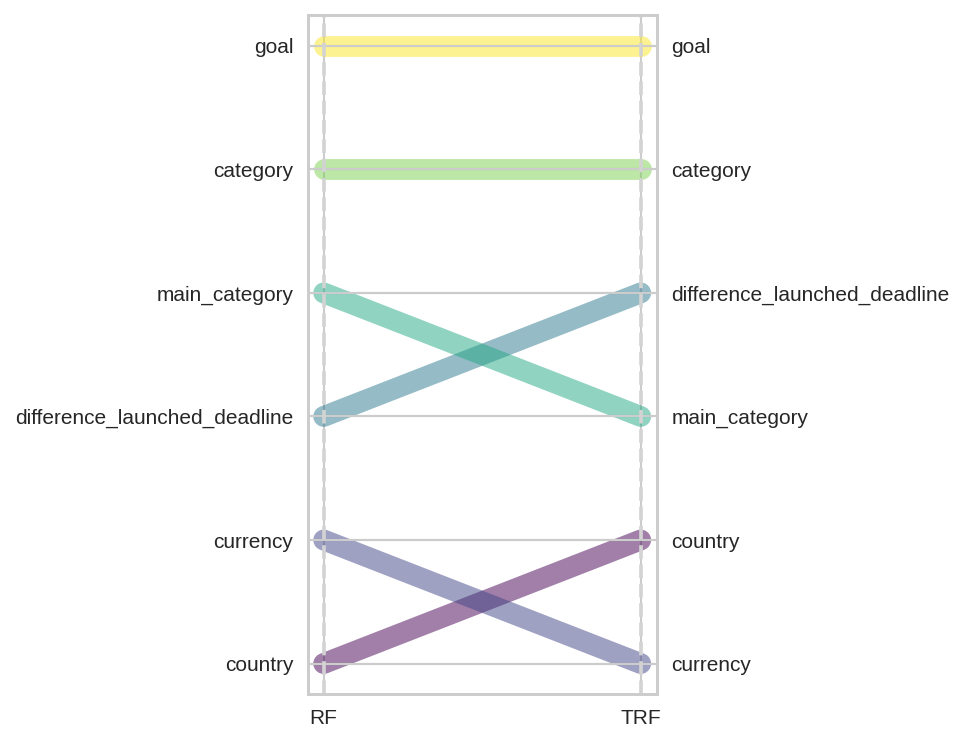

In [73]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

In [74]:
results_trt

{'round': [],
 'holdout_performance': [0.6539838612949642,
  0.6553381502445699,
  0.653756447072543],
 'feature_importance': [goal                            0.071686
  difference_launched_deadline    0.001047
  country                         0.000000
  currency                        0.000056
  category                        0.030654
  main_category                   0.001028
  Name: 2013, dtype: float64,
  goal                            0.079117
  difference_launched_deadline    0.002180
  country                         0.001147
  currency                       -0.000155
  category                        0.023949
  main_category                   0.001632
  Name: 2012, dtype: float64,
  goal                            0.078980
  difference_launched_deadline    0.001887
  country                         0.000000
  currency                        0.000000
  category                        0.022482
  main_category                   0.000822
  Name: 2011, dtype: float64],
 'sample_s

## Reverse Learning Curve

,2013,2012,2011
goal,0.071686,0.079117,0.078980
difference_launched_deadline,0.001047,0.002180,0.001887
country,0.000000,0.001147,0.000000
currency,0.000056,0.000155,0.000000
category,0.030654,0.023949,0.022482
main_category,0.001028,0.001632,0.000822


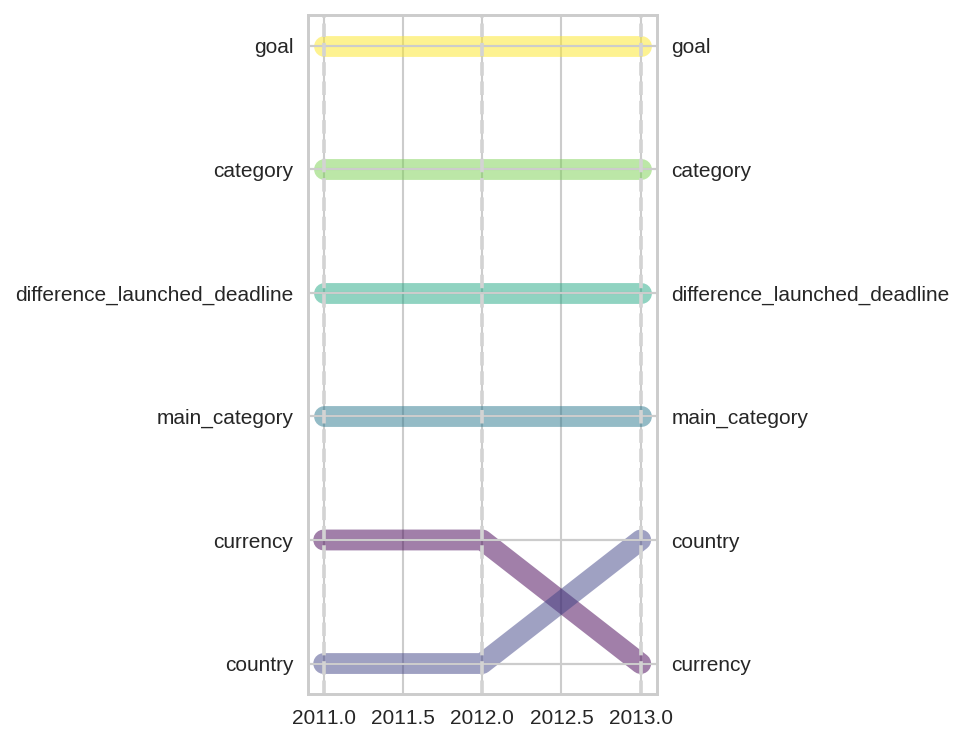

In [75]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

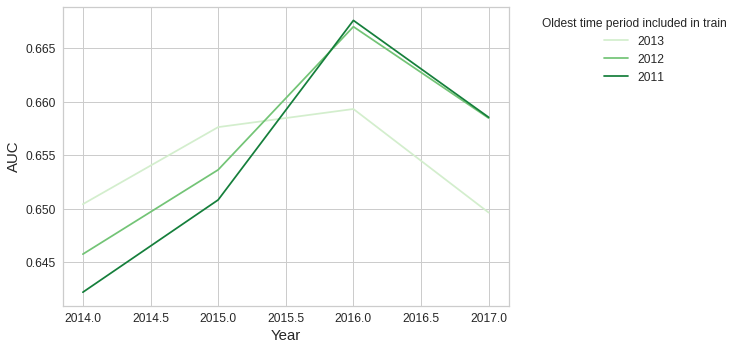

In [76]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

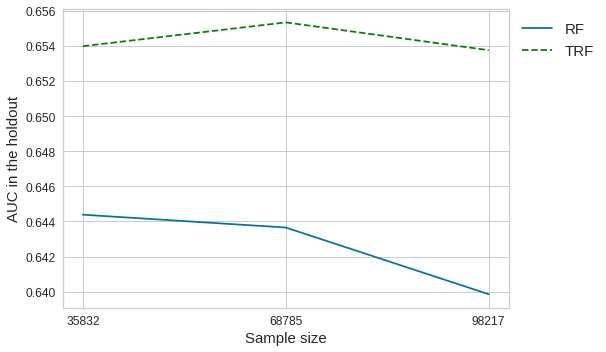

In [77]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

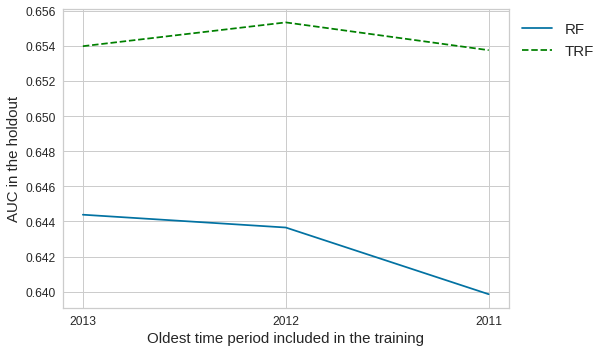

In [78]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

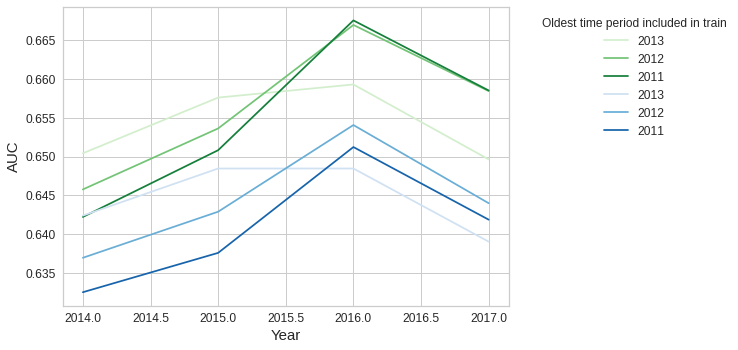

In [79]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

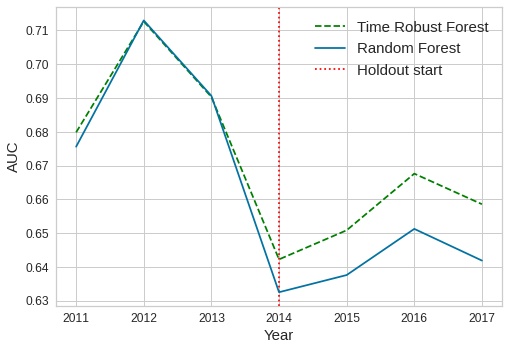

In [80]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

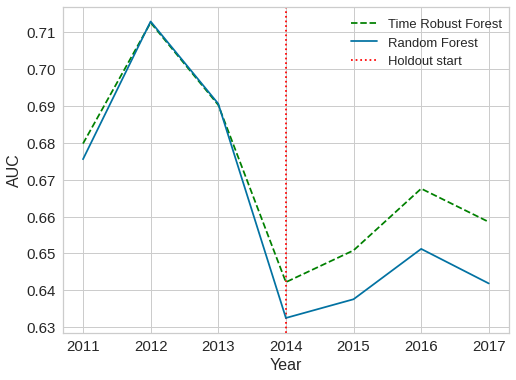

In [145]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, 
           bbox_to_anchor=(0.62, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [82]:
challenger_model.feature_importance()

,Importance
Feature,
goal,4855
category,3582
main_category,7
LEAF,5
difference_launched_deadline,5


In [83]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['goal', 'difference_launched_deadline', 'category', 'main_category']

In [84]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['goal', 'difference_launched_deadline', 'category', 'main_category']

In [85]:
selected_features

['goal', 'difference_launched_deadline', 'category', 'main_category']

In [86]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6475,0.7051,0.6730,0.5856,0.6263,0.2958,0.2983
1,0.6503,0.7087,0.6625,0.5905,0.6244,0.2993,0.3011
2,0.6396,0.7028,0.6731,0.5765,0.6211,0.2814,0.2845
3,0.6471,0.7081,0.6576,0.5874,0.6205,0.2927,0.2943
4,0.6482,0.7021,0.6619,0.5881,0.6228,0.2954,0.2972
Mean,0.6466,0.7053,0.6656,0.5856,0.6230,0.2929,0.2951
SD,0.0036,0.0027,0.0063,0.0048,0.0021,0.0061,0.0057


In [87]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [88]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [89]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.7239559450499766
0.7032002263191833
0.6613029214790184


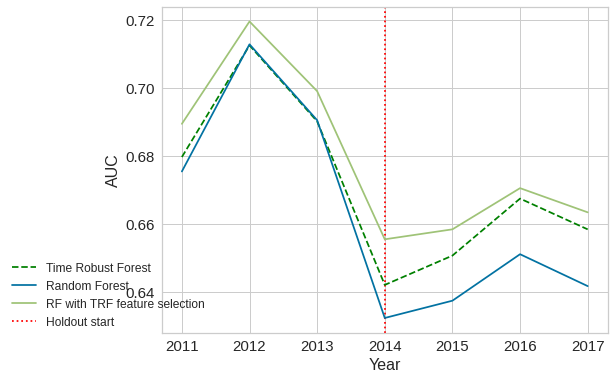

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="RF with TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=12, bbox_to_anchor=(0.12, 0.25))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [96]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

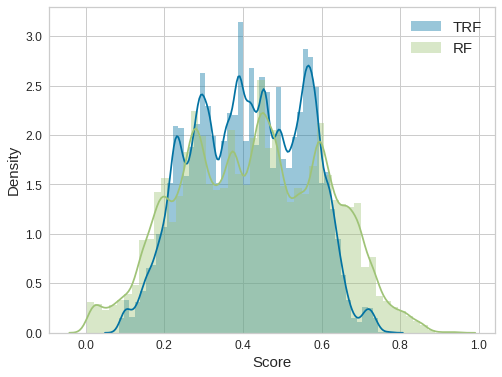

In [97]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [98]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

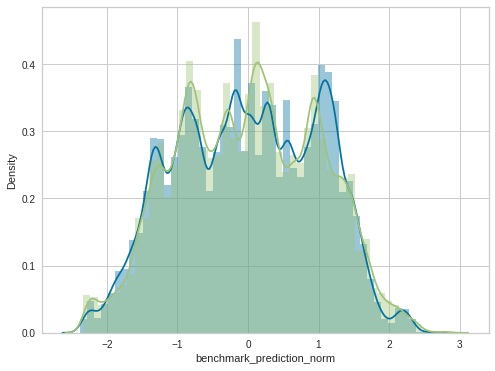

In [99]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [100]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(101771, 6)
(152658, 6)


In [101]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['goal', 'difference_launched_deadline']

In [102]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [103]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:47 Time:  0:00:47
100% (11 of 11) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


In [104]:
# pred_test = gam_challenger.predict(X_test[features])
# print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

# pred_test = gam_benchmark.predict(X_test[features])
# print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

In [105]:
X_test.describe()

,goal,difference_launched_deadline,country,currency,category,main_category
count,152658.000000,152658.000000,152658.000000,152658.000000,152658.000000,152658.000000
mean,25431.381768,32.230070,17.695856,10.260825,79.428271,7.504566
std,65440.390268,11.437408,7.015103,4.413916,46.536819,3.958423
min,50.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.000000,29.000000,12.000000,5.000000,39.000000,5.000000
50%,6000.000000,29.000000,22.000000,13.000000,84.000000,7.000000
75%,20000.000000,34.000000,22.000000,13.000000,115.000000,11.000000
max,500000.000000,59.000000,22.000000,13.000000,158.000000,14.000000


goal
0


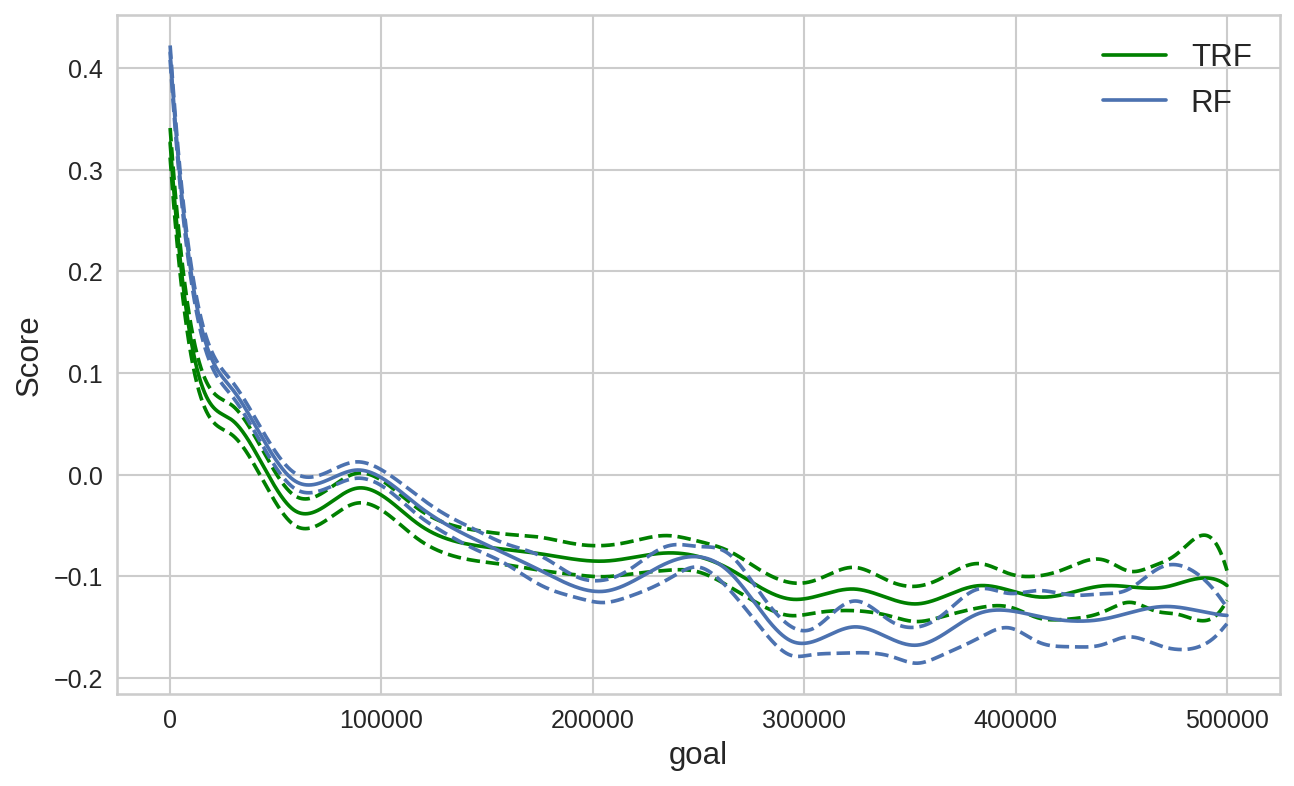

difference_launched_deadline
1


OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 576x432 with 0 Axes>

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 1500x900 with 1 Axes>

In [106]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
    XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

country


No handles with labels found to put in legend.


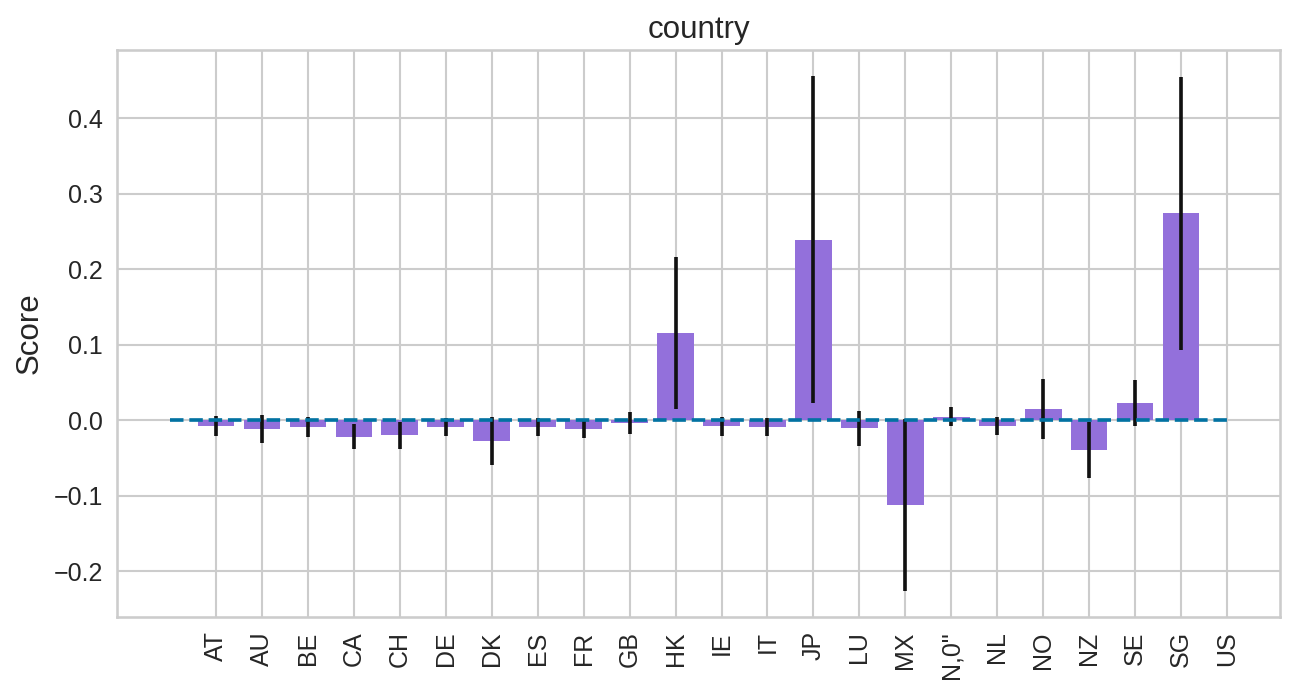

currency


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

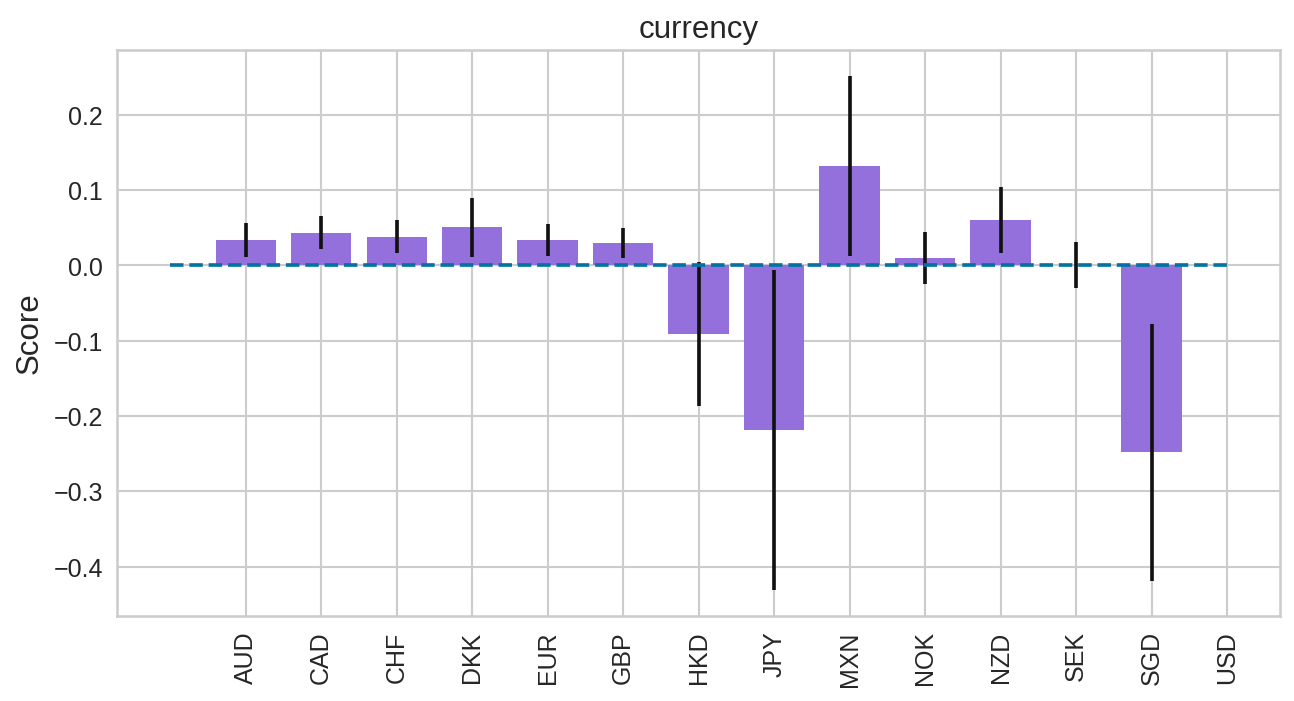

category
main_category


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

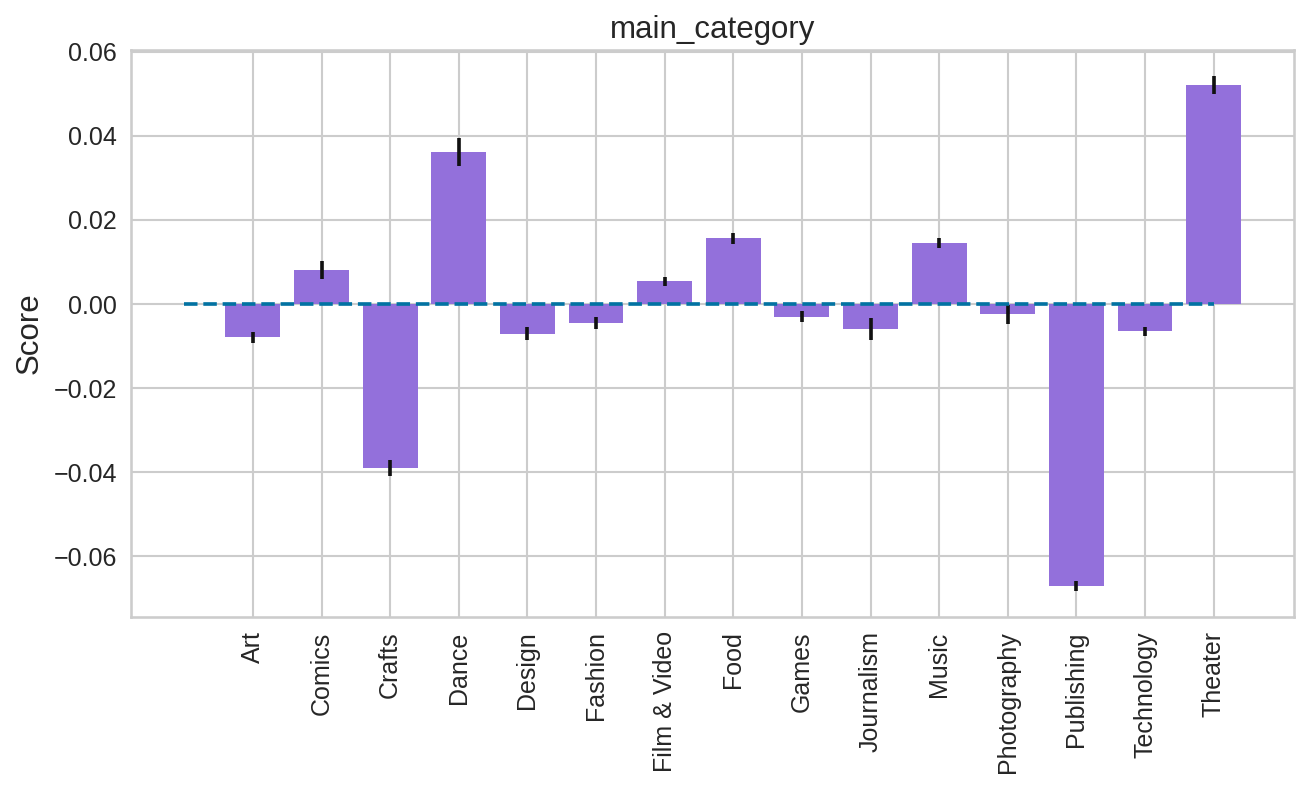

<Figure size 576x432 with 0 Axes>

In [107]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        #try:
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        agg = data.groupby(feat).mean()

        impact_plot = plt.bar([i for i in range(len(agg))],
                              agg["Mean Impact"],
                              yerr=agg[["low", "high"]].values.transpose(),
                              color="#9370DB",
                              capsize=7)

        plt.title(feat, fontsize=15)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)

        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

        plt.show()
        plt.clf()
#         except:
#             print("No plot for {}".format(feat))
plt.show()

In [ ]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))

        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [ ]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [ ]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

challenger_params = challenger_opt_param.copy()
challenger_params.pop("min_sample_periods")
for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        min_sample_periods=min_sample_periods,
                                        multi=True,
                                        **challenger_params)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

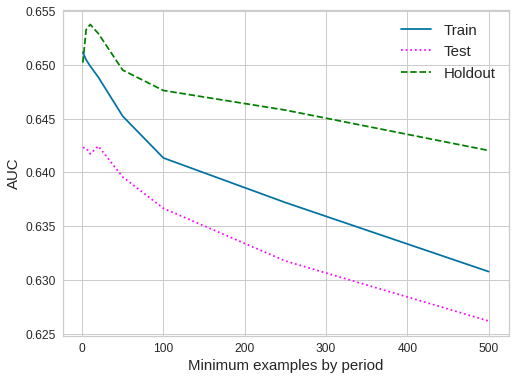

In [143]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

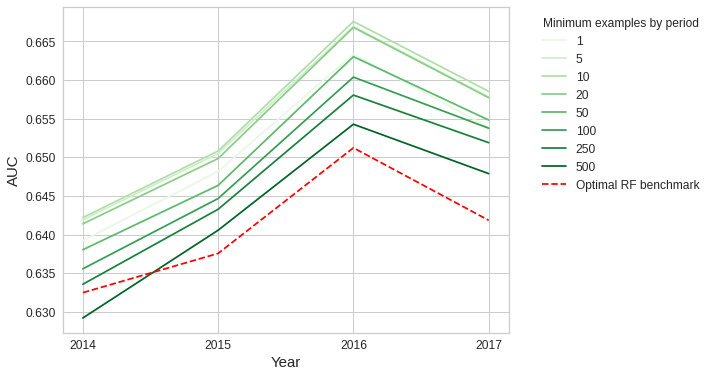

In [142]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

bench_params = benchmark_opt_param.copy()
bench_params.pop("min_sample_periods")

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       min_sample_periods=training_segments * min_sample_periods,
                                       **bench_params)
    
    
    model.fit(train[features + [DUMMY_TIME_COLUMN]],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

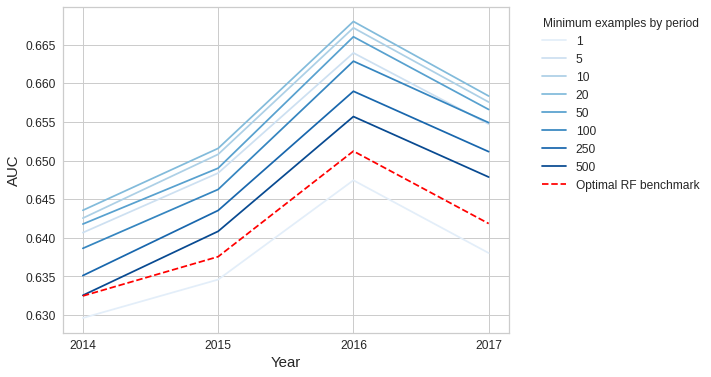

In [138]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

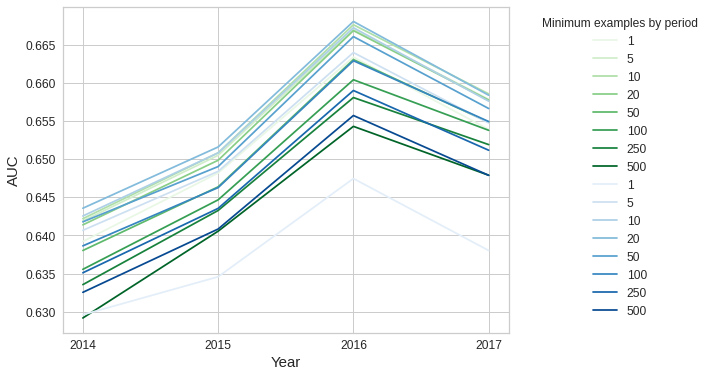

In [139]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

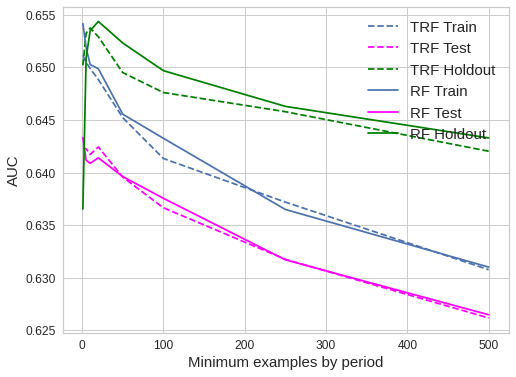

In [140]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

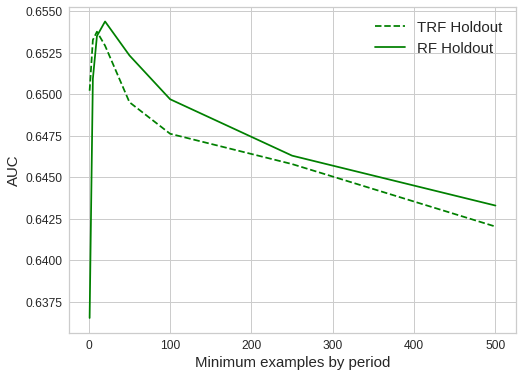

In [141]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [ ]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [ ]:
domain_data = pd.concat([train, test, out_of_time])

In [ ]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [ ]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

In [ ]:
domain_model = tuned_domain_rf

In [ ]:
domain_model.fit(train_domain[features], train_domain["domain"])

In [ ]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [137]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.8255058023601775

## Other optimization design for the RF

In [ ]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

In [ ]:
posfix = str(last_time_segment_in_train)

In [ ]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                      optimize="AUC",
                      n_iter=25)

In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

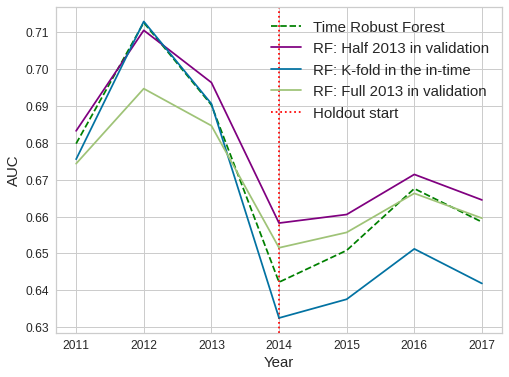

In [136]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()
